﻿# 推理和验证

在训练神经网络之后，你现在可以使用它来进行预测。这个过程通常称为**推理**过程，这一术语来自统计学。然而，神经网络在面对训练数据时往往表现得太过优异，因而无法泛化到未见过的数据。这称之为**过拟合**，会影响推理效果。为了在训练中测试过拟合情况，我们会使用非训练集中的数据（称为**验证集**）衡量效果。在训练期间监测验证效果时，我们使用正则化避免过拟合。在此 notebook 中，我将演示如何在 PyTorch 中防止过拟合。 

和之前一样，首先通过 torchvision 加载数据集。这次，我们将使用测试集，你可以通过设置 `train=False` 获得测试集：

In [ ]:
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

测试集包含和训练集相似的图像。通常，我们会将原始数据集的 10-20% 作为测试和验证集，剩下的用于训练。

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


现在我将创建一个正常模型，使用 Part 4 notebook 答案中的模型。

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

验证的目的是衡量模型在非训练集数据上的效果。效果标准由开发者自己决定。通常用准确率表示，即网络预测正确的类别所占百分比。其他标准包括[精确率和召回率](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))以及 top-5 错误率。我们将侧重于准确率。首先，我将使用测试集中的一批数据进行前向传播。

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [ ]:
torch.Size([64, 10])


算出概率后，我们可以使用 `ps.topk` 方法获得概率最高的类别。它会返回前 $k$ 个值。因为我们只需概率最高的类别，因此可以使用 `ps.topk(1)`。它会返回 top-$k$ 值和 top-$k$ 索引元组。如果最高值是第 5 个元素，索引将是 4。

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 3],
        [ 4]])


In [ ]:
tensor([[ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1]])


现在检查预测类别与标签是否匹配。很简单，只需检测 `top_class` 和 `labels` 是否相等，但是要注意形状。`top_class` 是一个二维张量，形状为 `(64, 1)`，而 `labels` 是一个一维张量，形状为 `(64)`。要检测对等性，`top_class` 和 `labels` 必须是相同的形状。

如果执行以下运算

In [6]:
equals = top_class == labels
print(equals)

tensor([[ 0,  0,  0,  ...,  1,  1,  0],
        [ 0,  0,  0,  ...,  1,  1,  0],
        [ 0,  0,  0,  ...,  1,  1,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], dtype=torch.uint8)


`equals` 的形状将为 `(64, 64)`，自己尝试一下。它会将 `top_class` 中每行的一个元素与 `labels` 中的每个元素进行比较，并针对每行返回 64 个True/False 布尔值。

In [8]:
equals = top_class == labels.view(*top_class.shape)
print(equals)

tensor([[ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 0],
        [ 0]], dtype=torch.uint8)


现在我们需要计算正确预测的百分比。`equals` 具有二元值，为 0 或 1。这就是说，如果将所有值相加并除以值的数量，就能获得正确预测的百分比。这个运算和求平均值一样，因此我们可以通过调用 `torch.mean` 获得准确率。听起来很简单？实际上，如果你用 `torch.mean(equals)`，就会报错：

In [ ]:
RuntimeError: mean is not implemented for type torch.ByteTensor

这是因为 `equals` 的类型是 `torch.ByteTensor`，但是 `torch.mean` 不适合这种类型的张量。因此我们需要将 `equals` 转换为浮点张量。注意，当我们执行 `torch.mean` 时，它会返回一个标量张量，要获得实际浮点值，我们需要进行 `accuracy.item()`。

In [9]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


In [ ]:
准确率：7.8125%


网络未经过训练，因此它做出的是随机猜测，准确率应该约为 10%。现在我们训练网络并包含验证过程，以便衡量网络在测试集上的效果。因为我们在验证过程中不会更新参数，因此可以使用 `torch.no_grad()` 关闭梯度，从而加快代码运行速度：

In [ ]:
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...

>**练习：**实现下面的验证循环并在循环之后输出总准确率。你可以复制粘贴上面的代码，但是建议自己编写，这样才能得到锻炼。通常，自己编写肯定比复制粘贴的学习效果要好。你应该可以取得 80% 以上的准确率。

In [11]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        # print(f'Accuracy: {accuracy.item()*100}%')
        
        # Turn off gradients for validation, saves memory and computations
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.459..  Test Accuracy: 0.830
Epoch: 2/30..  Training Loss: 0.396..  Test Loss: 0.410..  Test Accuracy: 0.855
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.391..  Test Accuracy: 0.858
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.387..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.400..  Test Accuracy: 0.860
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.368..  Test Accuracy: 0.871
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.372..  Test Accuracy: 0.874
Epoch: 8/30..  Training Loss: 0.279..  Test Loss: 0.368..  Test Accuracy: 0.874
Epoch: 9/30..  Training Loss: 0.271..  Test Loss: 0.369..  Test Accuracy: 0.873
Epoch: 10/30..  Training Loss: 0.263..  Test Loss: 0.375..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.443..  Test Accuracy: 0.855
Epoch: 12/30..  Training Loss: 0.253..  Test Loss: 0.387..  Test Accuracy: 0.873
Epoch: 13/30..  Training Loss: 0.244.

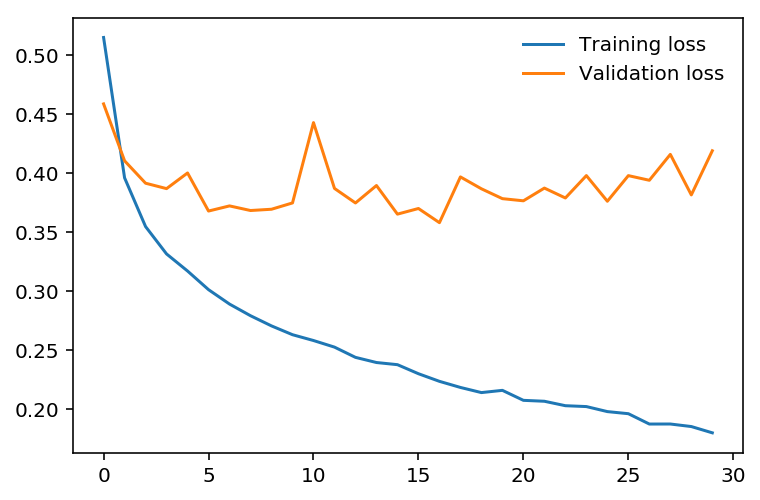

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## 过拟合

如果我们观察训练过程中的训练和验证损失，就能发现一种叫做过拟合的现象。

<img src='assets/overfitting.png' width=450px>

网络能越来越好地学习训练集中的规律，导致训练损失越来越低。但是，它在泛化到训练集之外的数据时开始出现问题，导致验证损失上升。任何深度学习模型的最终目标是对新数据进行预测，因此我们要尽量降低验证损失。一种方法是使用验证损失最低的模型，在此例中是训练周期约为 8-10 次的模型。这种策略称为*早停法* (early stopping)。在实践中，你需要在训练时频繁地保存模型，以便之后选择验证损失最低的模型。

最常用的减少过拟合方法（早停法除外）是*丢弃*，即随机丢弃输入单元。这样就促使网络在权重之间共享信息，使其更能泛化到新数据。在 PyTorch 中添加丢弃层很简单，使用 [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) 模块即可。

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

在训练过程中，我们需要使用丢弃防止过拟合，但是在推理过程中，我们需要使用整个网络。因此在验证、测试和使用网络进行预测时，我们需要关闭丢弃功能。你可以使用 `model.eval()`。它会将模型设为验证模式，使丢弃率变成 0。也可以使用 `model.train()` ，将模型设为训练模式，重新开启丢弃功能。通常，验证循环的规律将为：关闭梯度，将模型设为评估模式，计算验证损失和指标，然后将模型重新设为训练模式。

In [ ]:
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()

> **练习：**向模型中添加丢弃并重新用 Fashion-MNIST 训练模型。看看你能否获得更低的验证损失或更高的准确率。

In [14]:
## TODO: Define your model with dropout added
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [15]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.610..  Test Loss: 0.466..  Test Accuracy: 0.826
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.476..  Test Accuracy: 0.833
Epoch: 3/30..  Training Loss: 0.449..  Test Loss: 0.419..  Test Accuracy: 0.852
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.449..  Test Accuracy: 0.843
Epoch: 5/30..  Training Loss: 0.416..  Test Loss: 0.423..  Test Accuracy: 0.852
Epoch: 6/30..  Training Loss: 0.410..  Test Loss: 0.396..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.399..  Test Loss: 0.407..  Test Accuracy: 0.858
Epoch: 8/30..  Training Loss: 0.404..  Test Loss: 0.403..  Test Accuracy: 0.863
Epoch: 9/30..  Training Loss: 0.388..  Test Loss: 0.406..  Test Accuracy: 0.856
Epoch: 10/30..  Training Loss: 0.391..  Test Loss: 0.400..  Test Accuracy: 0.858
Epoch: 11/30..  Training Loss: 0.382..  Test Loss: 0.381..  Test Accuracy: 0.865
Epoch: 12/30..  Training Loss: 0.385..  Test Loss: 0.402..  Test Accuracy: 0.863
Epoch: 13/30..  Training Loss: 0.380.

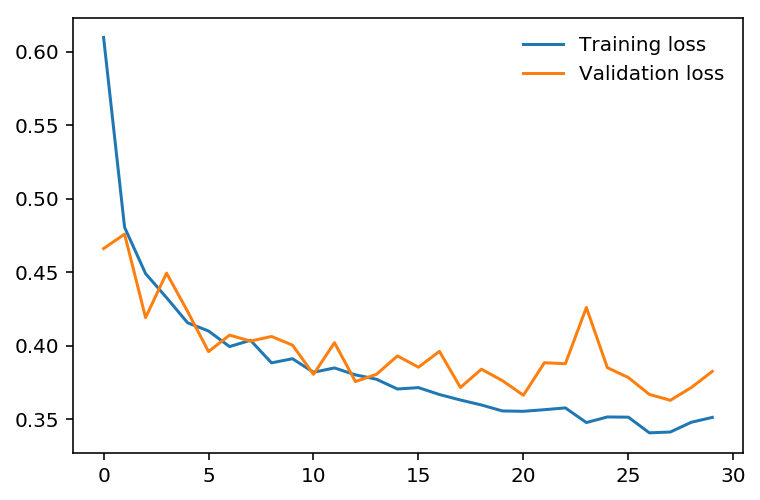

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## 推理

训练好模型后，我们可以用它推理了。之前已经进行过这一步骤，但是现在需要使用 `model.eval()` 将模型设为推理模式。对于 `torch.no_grad()`，你需要关闭 autograd。

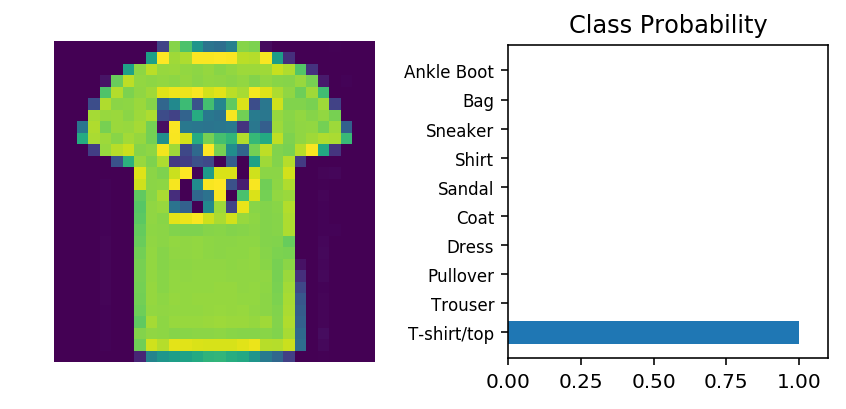

In [19]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

![png](output_19_0.png)


## 下一步！

在下个部分，我将介绍如何保存训练的模型。我们肯定不希望每次要用到模型的时候都临时训练，而是希望能保存模型，然后在继续训练时或使用模型推理时再加载模型，所以我们需要学会保存和加载模型。